In [1]:
%run ./engine_gandalf_wintermute.py
%run ./functions_gandalf_wintermute.py

5.13.1


In [2]:
def test_timeframe(tf):
    tf=tf.lower()
    return int(tf.split("min")[0])
    
def resample_TradeStaion_version(original_tf,resample_tf,dataset):
    
    
    original_tf=test_timeframe(original_tf)
    resample_tf=test_timeframe(resample_tf)
    
    df_0=dataset.copy()
    
    df_0.index=df_0.index - pd.DateOffset(minutes=original_tf)
    df_resample=df_0.resample(str(resample_tf)+'Min').agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last','volume':'sum'})
    
    if resample_tf == "1440" :
        df_resample = df_resample
    else:
        df_resample.index=df_resample.index + pd.DateOffset(minutes=resample_tf)
        
    df_resample.index=pd.to_datetime(df_resample.index)
    df_resample=df_resample.dropna()
    return df_resample


def load_data(filename,original_tf,resample_tf):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    
    import datetime
    start = datetime.datetime.now()
    data = pd.read_csv(filename, parse_dates = [['Date', 'Time']])
  
    if "Down" in data.columns.to_list():
        data=data[['Date_Time','Open','High','Low','Close','Up','Down']]
        data.columns = ["date_time","open","high","low","close","up","down"]
        data.set_index('date_time', inplace = True)
        data['volume'] = data['up'] + data['down']
        data.drop(['up','down'], axis = 1,inplace = True)
    else:
        data=data[['Date_Time','Open','High','Low','Close','Volume']]
        data.columns = ["date_time","open","high","low","close","volume"]
        data.set_index('date_time', inplace = True)
    
    data = resample_TradeStaion_version(original_tf,resample_tf,data)
    
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    
    
    end = datetime.datetime.now()
    print("loaded", len(data), "records in", end - start)
    
    return data.dropna()

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")


def OPEN(dataset):
    return dataset["open"]
def HIGH(dataset):
    return dataset["high"]
def LOW(dataset):
    return dataset["low"]
def CLOSE(dataset):
    return dataset["close"]

def High_Close(serie):
    return (serie.iloc[:,1] - serie.iloc[:,3])
def High_Open(serie):
    return (serie.iloc[:,1] - serie.iloc[:,0])
def Low_Close(serie):
    return (serie.iloc[:,2] - serie.iloc[:,3])
def Low_Open(serie):
    return (serie.iloc[:,2] - serie.iloc[:,0])

def avg_true_range(dataframe, period):
    dataframe["M1"] = dataframe.high - dataframe.low
    dataframe["M2"] = abs(dataframe.high - dataframe.low.shift(1)).fillna(0)
    dataframe["M3"] = abs(dataframe.low - dataframe.close.shift(1)).fillna(0)
    dataframe["Max"] = dataframe[["M1", "M2", "M3"]].max(axis = 1)
    dataframe["MeanMax"] = dataframe["Max"].rolling(period).mean()
    return dataframe.MeanMax.fillna(0)

def RSI(series, period):
    """
    Function to calculate the Relative Strength Index of a close serie
    """
    df = pd.DataFrame(series, index = series.index)
    df["chg"] = series.diff(1)
    df["gain"] = np.where(df.chg > 0, 1, 0)
    df["loss"] = np.where(df.chg <= 0, 1, 0)
    df["avg_gain"] = df.gain.rolling(period).sum() / period * 100
    df["avg_loss"] = df.loss.rolling(period).sum() / period * 100
    rs = abs(df["avg_gain"] / df["avg_loss"])
    rsi = 100 - (100 / (1 + rs))
    return rsi

def MFI(df, period):
    """
    Function to calculate the Money Flow Index of a price serie (OHLCV)
    """
    df["typical_price"] = (df.iloc[:,1] + df.iloc[:,2] + df.iloc[:,3]) / 3
    df["raw_money_flow"] = df.typical_price * df.iloc[:,4]
    df["chg"] = df.raw_money_flow.diff(1)
    df["pos_money_flow"] = np.where(df.chg > 0,1,0)
    df["neg_money_flow"] = np.where(df.chg <= 0,1,0)
    df["avg_gain"] = df.pos_money_flow.rolling(period).sum() / period * 100
    df["avg_loss"] = df.neg_money_flow.rolling(period).sum() / period * 100
    mfr = abs(df["avg_gain"] / df["avg_loss"])
    mfi = 100 - (100 / (1 + mfr))
    return mfi

def BollingerBand(serie,period,multiplier,upper_lower):
    if upper_lower == 0:
        return serie.rolling(period).mean() + multiplier * serie.rolling(period).std()
    if upper_lower == 1:
        return serie.rolling(period).mean() - multiplier - serie.rolling(period).std()

def ROC(serie,period):
    return ((serie / serie.shift(period)) - 1) * 100

def Momentum(serie,period):
    return (serie - serie.shift(period))

def SMA(serie,period):
    return serie.rolling(period).mean()


### Carico Resample serie storica

In [4]:
FILENAME = "data/@GC_60min_Exchange.txt"

%time  dataset0 = load_data(FILENAME,"60min","240min")
dataset0.head()

loaded 25917 records in 0:00:08.186897
Wall time: 8.19 s


,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2007-01-01 20:00:00,1008.7,1009.8,1008.0,1008.6,1316,0,1,1,2007,1,1,20,0
2007-01-02 00:00:00,1008.9,1009.7,1008.5,1009.3,1124,1,2,1,2007,2,1,0,0
2007-01-02 04:00:00,1009.3,1011.1,1009.0,1011.0,1239,1,2,1,2007,2,1,4,0
2007-01-02 08:00:00,1011.2,1013.0,1010.8,1011.3,2868,1,2,1,2007,2,1,8,0
2007-01-02 12:00:00,1011.4,1012.9,1010.7,1012.0,8117,1,2,1,2007,2,1,12,0


In [5]:
dataset = dataset0.copy()

In [6]:
entry_rule_long = eval('(SMA(MedBodyPrice(dataset),156).shift(2)>SMA(MedPrice(dataset),125).shift(4)) & (avg_true_range(dataset,113).shift(0)>avg_true_range(dataset,156).shift(0)) & (SMA(HIGH(dataset),44).shift(0)>LOW(dataset).shift(0))')

exit_long = 6
costi = 30 


In [7]:
dataset["entry_rule_short"] = eval('(SMA(MedBodyPrice(dataset),114).shift(4)>SMA(LOW(dataset),173).shift(0)) & (MFI(dataset,167).shift(4)<MFI(dataset,49).shift(2)) & (trix(dataset,164).shift(0)<trix(dataset,181).shift(0))')

In [7]:
def test_long(dataset,exit_long,costi,entry_rule_long):

    dataset["entry_rule_long"] = entry_rule_long

    NAME = "Tester"

    WRITELOG = False

    EXIT_ON_ENTRY_BAR = False
    CONSECUTIVE_TRADES = True

    COSTS_FIXED = costi
    # 10 for 10 $ for each transaction (2 * fee each operation)
    COSTS_VARIABLE = 0.0
    # 1.0 for 1% (2 * fee each operation)
    COSTS_PERSHARES = 0.0 
    # 0.01 for 1 cent for each shares traded (2 * fee each operation)

    INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
    TICK = 0.01
    BIGPOINTVALUE = 100
    ORDER_TYPE = "market"
    MAX_INTRADAY_OPERATIONS = 100

    QUANTITY = 1
    MARGIN_PERCENT = 10 # margin to use in capital calculation

    TIME_EXIT = exit_long  # 0 to disable
    TIME_EXIT_LOSS = 0  # 0 to disable
    TIME_EXIT_GAIN = 0  # 0 to disable

    MONEY_STOPLOSS = 0  # 0 to disable
    MONEY_TARGET = 0  # 0 to disable

    MIN_MONEY_PERCENT_STOPLOSS = 0
    PERCENT_STOPLOSS = 0.0  # 0 to disable

    MIN_MONEY_PERCENT_TARGET = 0
    PERCENT_TARGET = 0.0  # 0 to disable

    enter_level = dataset.high

    exit_rules_loss = False

    exit_rules_gain = False 

    target_level = 0 # 0 to disable

    stop_level = 0 # 0 to disable

    DIRECTION = "long"

    enter_rules = dataset["entry_rule_long"]

    exit_rules = False

    tradelist_long, open_equity_long, closed_equity_long, operation_equity_long = apply_trading_system_opt(dataset, INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                                   COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                                   ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                                   exit_rules, exit_rules_loss, exit_rules_gain,
                                                                                   target_level, stop_level,
                                                                                   TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                                   MONEY_STOPLOSS, MONEY_TARGET, 
                                                                                   PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                                   PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

    # True: Interactive, False: Static
    #performance_report(dataset, tradelist_long, closed_equity_long, open_equity_long, 100000, 0, MARGIN_PERCENT, False)
    return tradelist_long

In [8]:
import talib as ta 

def faster_supertrend_talib(high, low, close, period, multiplier):
    
    high = high.values
    low = low.values
    close = close.values   
    
    avg_price = ta.MEDPRICE(high, low)
    atr = ta.ATR(high, low, close, period)
    upper, lower = get_basic_bands(avg_price, atr, multiplier)
    return get_final_bands_nb(close, upper, lower)


def get_basic_bands(med_price, atr, multiplier):
    matr = multiplier * atr
    upper = med_price + matr
    lower = med_price - matr
    return upper, lower

from numba import njit
@njit
def get_final_bands_nb(close, upper, lower):
    trend = np.full(close.shape, np.nan)
    dir_ = np.full(close.shape, 1)
    long = np.full(close.shape, np.nan)
    short = np.full(close.shape, np.nan)

    for i in range(1, close.shape[0]):
        if close[i] > upper[i - 1]:
            dir_[i] = 1
        elif close[i] < lower[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lower[i] < lower[i - 1]:
                lower[i] = lower[i - 1]
            if dir_[i] < 0 and upper[i] > upper[i - 1]:
                upper[i] = upper[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lower[i]
        else:
            trend[i] = short[i] = upper[i]
            
    return trend , dir_ , long , short


def analisi(tradelist):
    import seaborn as sns; sns.set()
    import plotly.express as px
    import mplfinance as fplt
    import datetime as dt
    
    import matplotlib.pyplot as plt
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 15})
    
    a=tradelist.operations.where(tradelist.operations>0).dropna().sum()
    b=abs(tradelist.operations.where(tradelist.operations<=0).dropna().sum())
    labels = 'Profit', 'Loss'
    sizes = [a,b]
    explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    colors= ["Green","Red"]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90,colors=colors,radius=2)
    #ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    gain_loss=[]
    for e in range(int(tradelist.bars_in_trade.max())+1):
        x=tradelist.operations.where(tradelist.bars_in_trade==e).dropna()
        if len(x)>0:
            x.cumsum().plot(figsize=(20,15),label="Exit a "+str(e)+" bar",title="Gain/Loss - Exit Bar",color='b')
            gain_loss.append([e,sum(x),len(x)])
            print("Operazione con uscita a",e,"barre:",len(x),"su",len(tradelist),"   ","Gain/Loss $:",sum(x))
    plt.legend()
    plt.show()

    df=pd.DataFrame(gain_loss)
    df.columns=(["barre_in_trade","gain_$","N_operazioni"])
    df.set_index(["barre_in_trade"],inplace=True)

    lista_grap=[df["gain_$"],df["N_operazioni"]]
    lista_x=['Barre in trade','Barre in trade']
    lista_y=['Gain/Loss','Numero Operazioni']
    lista_title=["Gain/Loss VS Bar in trade","Numero Operazioni VS Bar in trade"]

    fig = plt.figure(figsize=(15, 7.5))
    columns = 2
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.bar(df.index, lista_grap[i-1],color='b')
        plt.title(lista_title[i-1],fontsize=10)
        plt.xlabel(lista_x[i-1],fontsize=10) 
        plt.ylabel(lista_y[i-1],fontsize=10) 
    plt.show()

    ora_open=[]
    day_open=[]
    mese_open=[]
    for e in range(len(tradelist)):
        x=tradelist.entry_date[e].hour
        ora_open.append(x)
        x=tradelist.entry_date[e].dayofweek
        day_open.append(x)
        x=tradelist.entry_date[e].month
        mese_open.append(x)

    tradelist["hour_open"]=ora_open
    tradelist["day_open"]=day_open
    tradelist["month_open"]=mese_open

    ora_close=[]
    day_close=[]
    mese_close=[]
    for e in range(len(tradelist)):
        x=tradelist.exit_date[e].hour
        ora_close.append(x)
        x=tradelist.exit_date[e].dayofweek
        day_close.append(x)
        x=tradelist.exit_date[e].month
        mese_close.append(x)

    tradelist["hour_close"]=ora_close
    tradelist["day_close"]=day_close
    tradelist["month_close"]=mese_close

    resHO=tradelist[["operations","hour_open"]]
    resHO=resHO.groupby(by=["hour_open"]).sum()
    resHC=tradelist[["operations","hour_close"]]
    resHC=resHC.groupby(by=["hour_close"]).sum()
    resDO=tradelist[["operations","day_open"]]
    resDO=resDO.groupby(by=["day_open"]).sum()
    resDC=tradelist[["operations","day_close"]]
    resDC=resDC.groupby(by=["day_close"]).sum()

    lista_grap=['resHO.operations.plot(kind="bar",title="Gain/Loss Hour - Open Time")',\
               'resHC.operations.plot(kind="bar",title="Gain/Loss Hour - Close Time")',\
                'resDO.operations.plot(kind="bar",title="Gain/Loss Weekday_open - Open Time")',\
                'resDC.operations.plot(kind="bar",title="Gain/Loss Weekday_close - CloseTime")']

    fig = plt.figure(figsize=(15, 15))
    columns = 2
    rows = 2
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        eval(lista_grap[i-1])
    plt.show()
    

    ######################################### DISTRIBUZIONE GAIN / LOSS #######################################################
    tradelist.operations.cumsum().plot(secondary_y=True,label="Strategy",title="Trend Analisi",color='b')
    plt.legend()
    dataset["ST"] , dataset["ST_signal"] , dataset["ST_long"] , dataset["ST_short"] =faster_supertrend_talib(dataset.high, dataset.low, dataset.close, 20, 3)   #### valori per super trend 
    dataset.close.plot(label="History_Data",color="gainsboro")
    dataset["ST_long"].plot(color="g",figsize=(20,10),label="Up_Trend")
    dataset["ST_short"].plot(color="r",label="Down_Trend")
    plt.legend()
    plt.show()

    ################################################# UP TRENDE ###############################################################
    dataset.close.plot(label="History_Data",color="gainsboro")
    dataset["ST_long"].plot(color="g",figsize=(20,10))

    up_trend=pd.concat([tradelist.operations,dataset["ST_long"]],axis=1)
    up_trend=up_trend.fillna(0)
    up_trend.iloc[:,1]=np.where(up_trend.iloc[:,1]>0,1,up_trend.iloc[:,1])
    up_trend["new_bal"]=0
    up_trend["new_bal"]=np.where(up_trend.iloc[:,1]==1,up_trend.iloc[:,0],up_trend.new_bal)
    res_up=up_trend["new_bal"].where((up_trend.operations!=0)&(up_trend.iloc[:,1]==1)).dropna()
    res_up.cumsum().plot(secondary_y=True,figsize=(20,10),title="Analisi Up_Trend",color='b')
    plt.show()
    up_cnt=len(res_up)
    print("Gain in Up_trend:",int(up_trend["new_bal"].sum()),"$","  in n°:",up_cnt,"operazioni")

    ################################################## DOWN TREND ##############################################################
    dataset.close.plot(label="History_Data",color="gainsboro")
    dataset["ST_short"].plot(color="r")

    down_trend=pd.concat([tradelist.operations,dataset["ST_short"]],axis=1)
    down_trend=down_trend.fillna(0)
    down_trend.iloc[:,1]=np.where(down_trend.iloc[:,1]>0,1,down_trend.iloc[:,1])
    down_trend["new_bal"]=0
    down_trend["new_bal"]=np.where(down_trend.iloc[:,1]==1,down_trend.iloc[:,0],down_trend.new_bal)
    res_down=down_trend["new_bal"].where((down_trend.operations!=0)&(down_trend.iloc[:,1]==1)).dropna()
    res_down.cumsum().plot(secondary_y=True,figsize=(20,10),title="Analisi down_Trend",color='b')
    plt.show()
    down_cnt=len(res_down)
    print("Gain in Down_trend:",int(down_trend["new_bal"].sum()),"$","  in n°:",down_cnt,"operazioni")
    return 

In [9]:
tradelist = test_long(dataset,exit_long,costi,entry_rule_long)

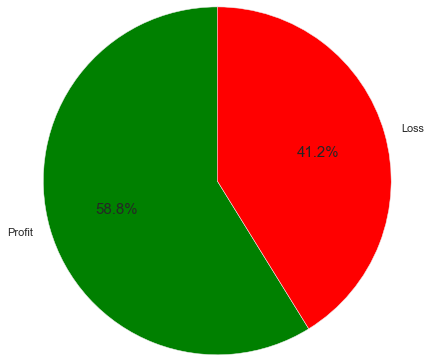

Operazione con uscita a 6 barre: 577 su 577     Gain/Loss $: 101060.0


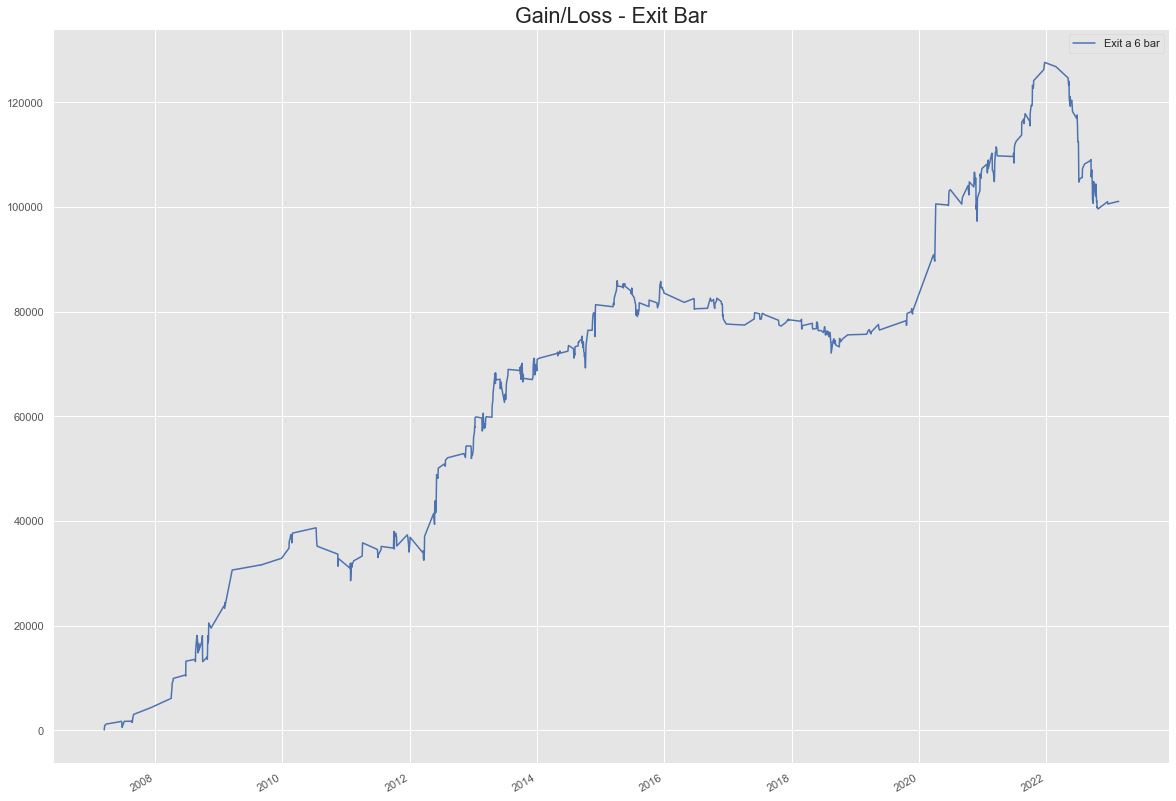

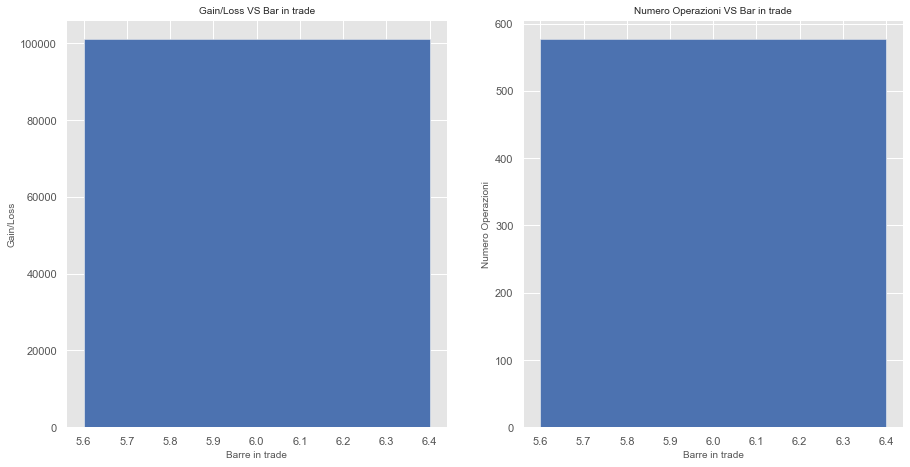

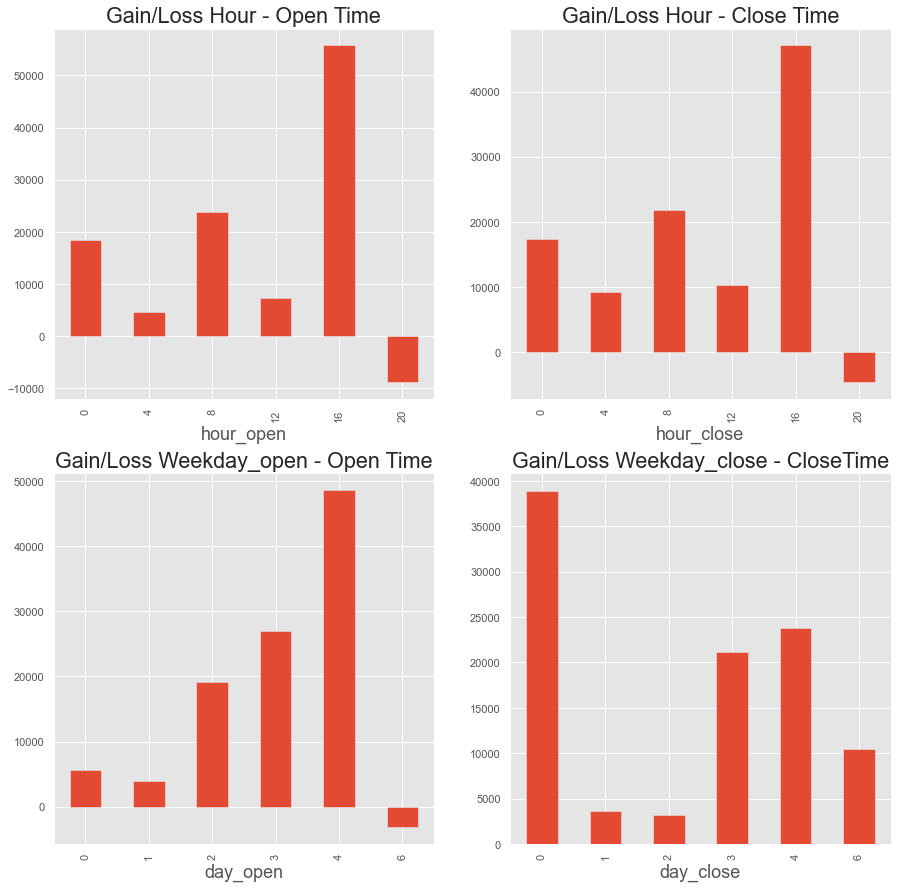

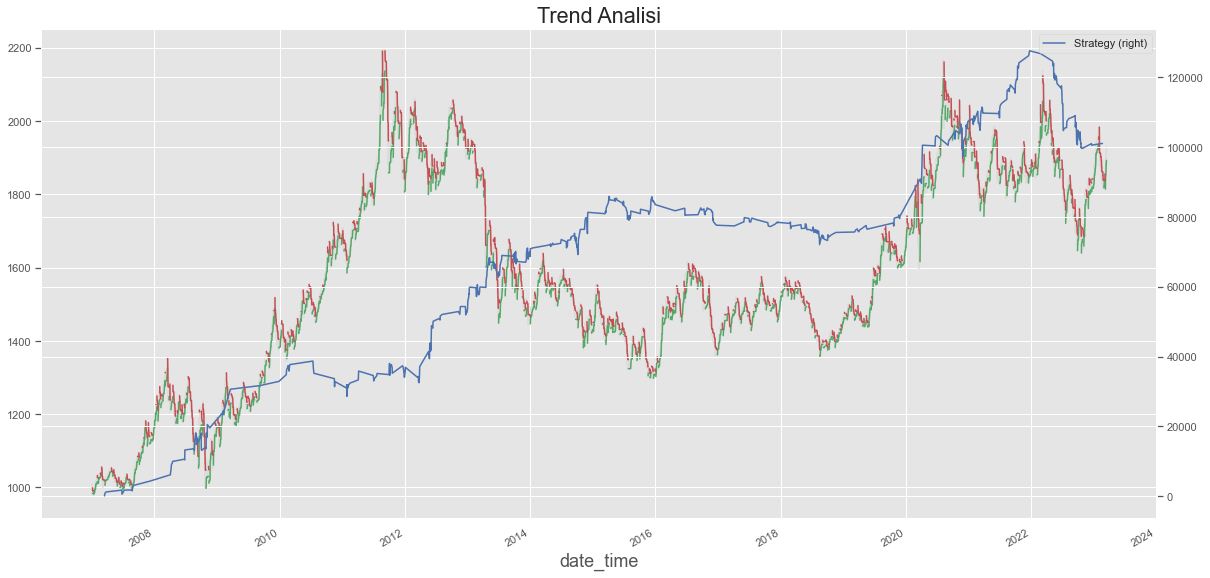

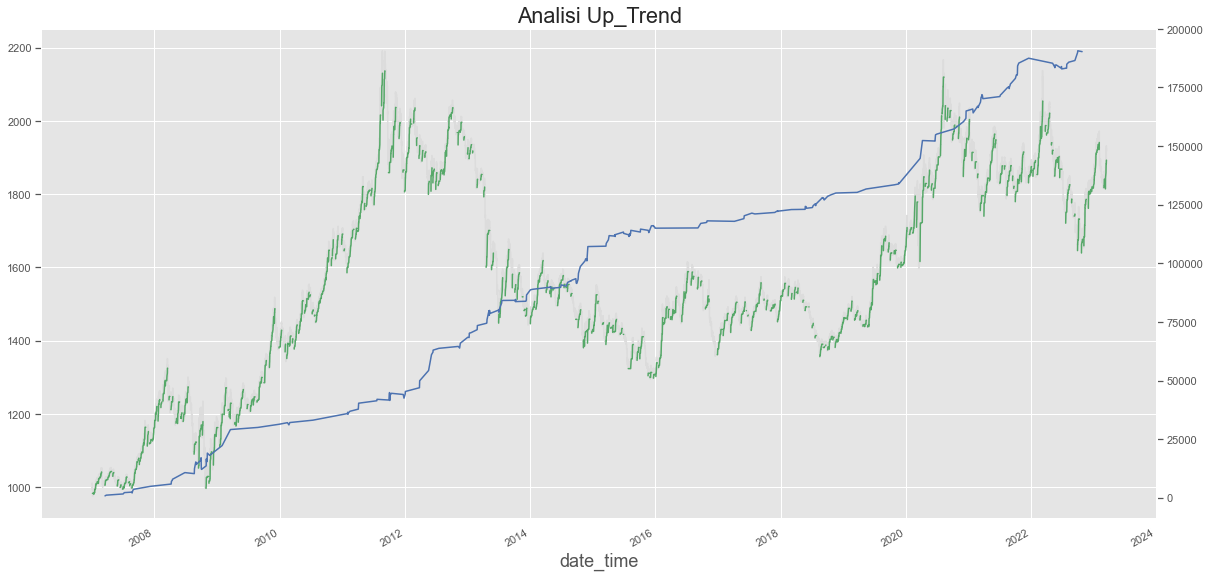

Gain in Up_trend: 190270 $   in n°: 264 operazioni


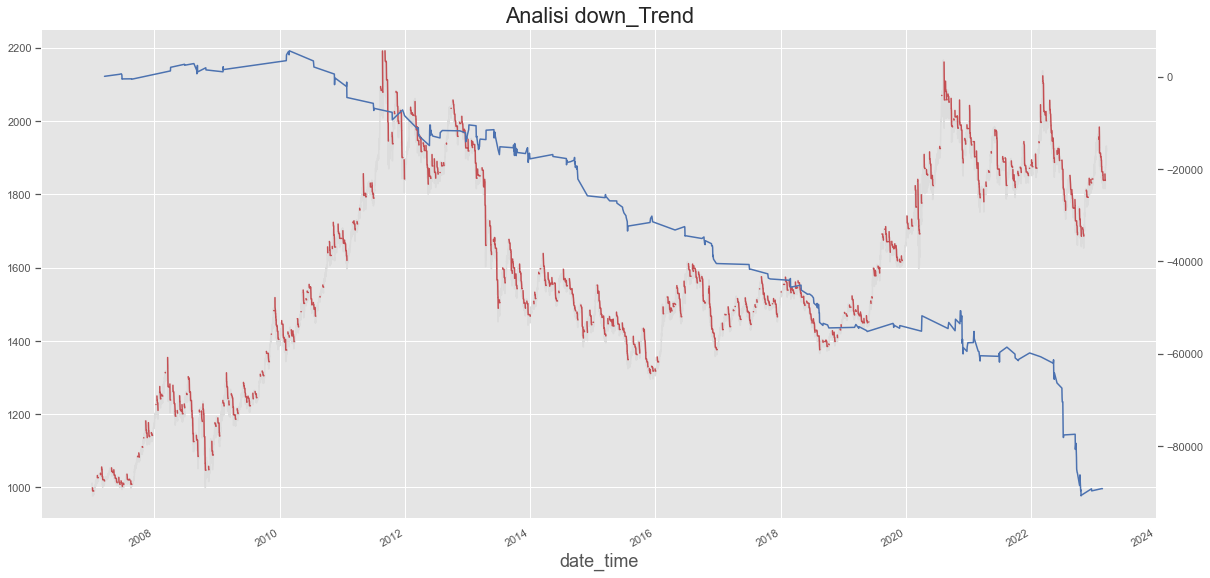

Gain in Down_trend: -89210 $   in n°: 310 operazioni


In [10]:
analisi(tradelist)

In [11]:
tradelist = test_long(dataset,exit_long,costi,entry_rule_long)
tradelist_entry_shift = test_long(dataset,exit_long,costi,entry_rule_long.shift(1 , fill_value=False))
tradelist_exit_anticipo = test_long(dataset,exit_long-1,costi,entry_rule_long)
tradelist_exit_ritardo = test_long(dataset,exit_long+1,costi,entry_rule_long)
tradelist_add_cost = test_long(dataset,exit_long,costi+20,entry_rule_long)

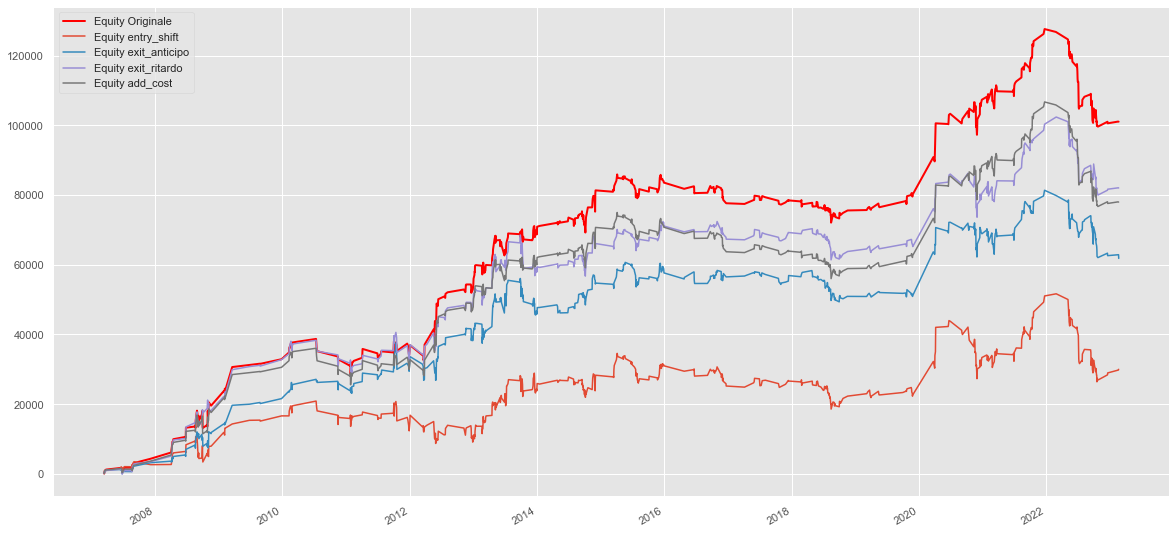

In [12]:
def performance_report_gen(tradelist):
    res=pd.DataFrame()
    d = {"Profit": round(tradelist.sum(),2),
         "MaxDD" : max_draw_down(tradelist),
         "Operations":operation_number(tradelist),
         "AverageTrade": avg_trade(tradelist),
         "ProfitFactor": profit_factor(tradelist),
         "PctWin": percent_win(tradelist),
         "KestnerRatio": kestner_ratio(tradelist),
         "gross_profit" :gross_profit(tradelist),
         "gross_loss" : gross_loss(tradelist),
         "Reward_Risk_Ratio": reward_risk_ratio(tradelist)}
    
    res=pd.DataFrame(data=d,index=[0])
    return res

def performances_validation_IS_OS(IS,OS,pct):

    ts1 = performance_report_gen(IS)
    ts2 = performance_report_gen(OS)

    ts1_string = "Equity_Originale"
    ts2_string = "Equity_Variata"

    ts1_pf = float(ts1.ProfitFactor)
    ts2_pf = float(ts2.ProfitFactor)
    ts1_at = float(ts1.AverageTrade)
    ts2_at = float(ts2.AverageTrade)
    ts1_rrr = float(ts1.Reward_Risk_Ratio)
    ts2_rrr = float(ts2.Reward_Risk_Ratio)
    ts1_mdd = float(ts1.MaxDD)
    ts2_mdd = float(ts2.MaxDD)

    cnt=0
    v1="FAILL !!!"
    v2="FAILL !!!"
    v3="FAILL !!!"
    v4="FAILL !!!"
    
    delta_pf=round(ts1_pf,2)-((round(ts1_pf,2)*pct)/100)
    if round(ts2_pf,2) >= round(ts1_pf,2)-((round(ts1_pf,2)*pct)/100):
        v1="OK"
        cnt=cnt+1
    print("Profit Factor      :", ts1_string, round(ts1_pf,2),"- ", ts2_string,  round(ts2_pf,2), 
          " -> delta:", delta_pf, v1)


    delta_at=round(ts1_at,2)-((round(ts1_at,2)*pct)/100)
    if round(ts2_at,2) >= round(ts1_at,2)-((round(ts1_at,2)*pct)/100):
        v2="OK"
        cnt=cnt+1
    print("Average Trade      :", ts1_string, round(ts1_at,2),"- ", ts2_string,  round(ts2_at,2), 
          " -> delta:", delta_at, v2)


    delta_rrr=round(ts1_rrr,2)-((round(ts1_rrr,2)*pct)/100)
    if round(ts2_rrr,2) >= round(ts1_rrr,2)-((round(ts1_rrr,2)*pct)/100):
        v3="OK"
        cnt=cnt+1
    print("Reward Risk Ratio  :", ts1_string, round(ts1_rrr,2),"- ", ts2_string, round(ts2_rrr,2), 
          " -> delta:", delta_rrr, v3)

    delta_DD=round(ts1_mdd,2)+((round(ts1_mdd,2)*pct)/100)
    if round(ts2_mdd,2) >= round(ts1_mdd,2)+((round(ts1_mdd,2)*pct)/100):
        v4="OK"
        cnt=cnt+1
    print("Max Draw Down      :", ts1_string, round(ts1_mdd,2),"- ", ts2_string,  round(ts2_mdd,2), 
          " -> delta:",delta_DD , v4)

    print("")
    print("")
    return cnt

tradelist.operations.cumsum().plot(figsize=(20,10),label="Equity Originale" ,color="red",linewidth=2)
tradelist_entry_shift.operations.cumsum().plot(figsize=(20,10),label="Equity entry_shift")
tradelist_exit_anticipo.operations.cumsum().plot(figsize=(20,10),label="Equity exit_anticipo" )
tradelist_exit_ritardo.operations.cumsum().plot(figsize=(20,10),label="Equity exit_ritardo")
tradelist_add_cost.operations.cumsum().plot(figsize=(20,10),label="Equity add_cost")
plt.legend()
plt.show()

In [13]:
print("Test entry_shift:")
print("")
performances_validation_IS_OS(tradelist.operations,tradelist_entry_shift.operations,20)
print("")
print("Test exit_anticipo:")
print("")
performances_validation_IS_OS(tradelist.operations,tradelist_exit_anticipo.operations,20)
print("")
print("Test exit_ritardo:")
print("")
performances_validation_IS_OS(tradelist.operations,tradelist_exit_ritardo.operations,20)
print("")
print("Test add_cost:")
print("")
performances_validation_IS_OS(tradelist.operations,tradelist_add_cost.operations,20)
print("")

Test entry_shift:

Profit Factor      : Equity_Originale 1.43 -  Equity_Variata 1.11  -> delta: 1.144 FAILL !!!
Average Trade      : Equity_Originale 175.15 -  Equity_Variata 51.98  -> delta: 140.12 FAILL !!!
Reward Risk Ratio  : Equity_Originale 1.18 -  Equity_Variata 1.08  -> delta: 0.944 OK
Max Draw Down      : Equity_Originale -16680.0 -  Equity_Variata -13880.0  -> delta: -20016.0 OK



Test exit_anticipo:

Profit Factor      : Equity_Originale 1.43 -  Equity_Variata 1.24  -> delta: 1.144 OK
Average Trade      : Equity_Originale 175.15 -  Equity_Variata 91.59  -> delta: 140.12 FAILL !!!
Reward Risk Ratio  : Equity_Originale 1.18 -  Equity_Variata 1.2  -> delta: 0.944 OK
Max Draw Down      : Equity_Originale -16680.0 -  Equity_Variata -16570.0  -> delta: -20016.0 OK



Test exit_ritardo:

Profit Factor      : Equity_Originale 1.43 -  Equity_Variata 1.33  -> delta: 1.144 OK
Average Trade      : Equity_Originale 175.15 -  Equity_Variata 155.65  -> delta: 140.12 OK
Reward Risk Ratio  

In [14]:
def gpdr(operationsIS, operationsOoS, step, tolerance):
    """
     Gandalf Persistence Distribution Ratio (GPDR)
     Versione evoluta: dividiamo i percentili in step blocchi e per ciascuno confrontiamo il valore numerico
     in In Sample ed in Out of Sample. Tolleriamo un degrado tra risultati In Sample ed Out of Sample
     di non oltre la tolerance.
    """
    operationsIS = pd.Series(operationsIS)
    operationsOoS = pd.Series(operationsOoS)
    #step = 0.1
    values = np.arange(0.0, 1.0 + step, step)
    #print(values)
    #print("")

    IS = 0
    OoS = 0
    for i in values:
        if operationsIS.quantile(i) > 0:
            if ((1 - tolerance) * operationsIS.quantile(i)) <= operationsOoS.quantile(i):
                OoS += 1
            else:
                IS += 1
            #print(round(i,2), 
            #      round(operationsIS.quantile(i), 2), 
            #      round((1 - tolerance) * operationsIS.quantile(i), 2),
            #      round(operationsOoS.quantile(i), 2), IS, OoS, )
        if operationsIS.quantile(i) <= 0:
            if ((1 + tolerance) * operationsIS.quantile(i)) <= operationsOoS.quantile(i):
                OoS += 1
            else:
                IS += 1
            #print(round(i,2),
            #      round(operationsIS.quantile(i), 2),
            #      round((1 + tolerance) * operationsIS.quantile(i), 2),
            #      round(operationsOoS.quantile(i), 2), IS, OoS, )
    
    best = round(OoS / len(values) * 100, 2)
    worst = round(IS / len(values) * 100, 2)
    
    #print("")
    #print("Gandalf Persistence Distribution Ratio (GPDR):", round(best / worst,2))
    #print("Gandalf Persistence Distribution Index (GPDI_OOS):", best, "%",)
    #print("Gandalf Persistence Distribution Index (GPDI_IS):", worst, "%")

    if (best == 0) | (worst ==0):
        return 0
    else:
        return round(best / worst,2)

def fast_GSA(dataframe,n_split):
    newdf_split = np.array_split(dataframe, n_split)
    return np.concatenate(newdf_split[0::2]) , np.concatenate(newdf_split[1::2])

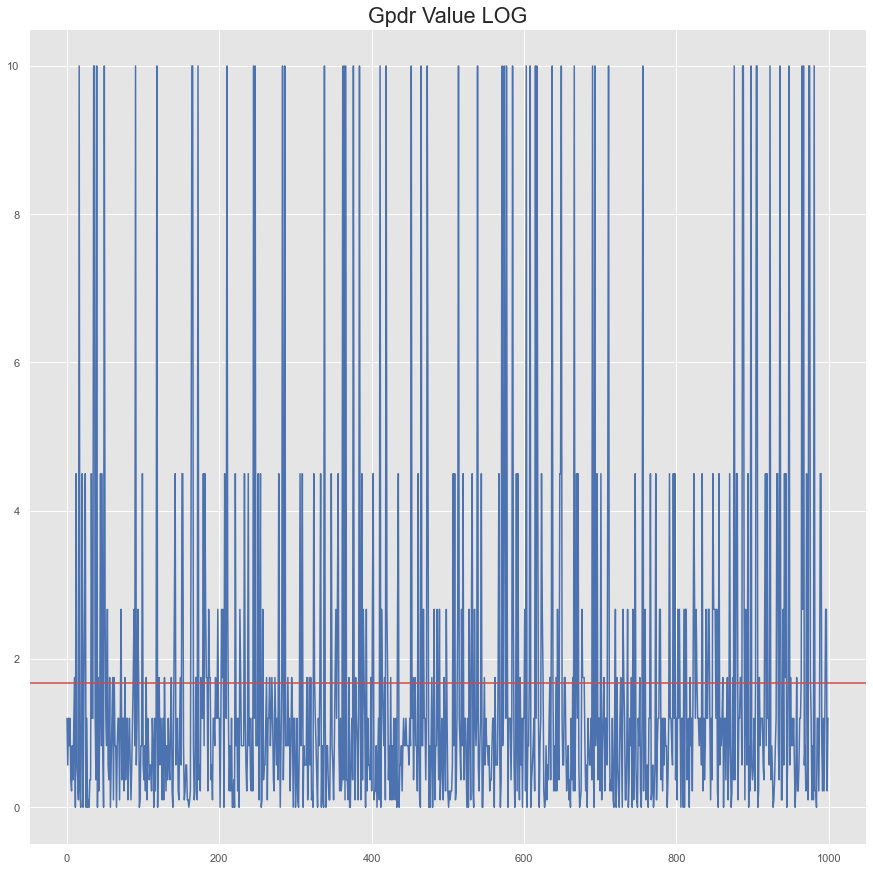

Gpdr medio : 1.68
Gpdr % su n° 1000 test : 48.5 %


In [15]:
from IPython.display import clear_output

newdf = tradelist.operations

gpdr_results = []

n_test=1000
stampa_test = 0
stampa_finale = 1

for i in tqdm(np.random.randint(10,100, size=n_test)):
    tradelist_IS , tradelist_OOS = fast_GSA(newdf,i)
    tmp_test = gpdr(tradelist_IS, tradelist_OOS, 0.1, 0.0)
    gpdr_results.append(tmp_test)
    if stampa_test == 1:
        clear_output(wait=True)
        pd.Series(gpdr_results).plot(figsize=(10,10),grid=True,title="Gpdr Value LOG",color='b')
        plt.show()
        
if stampa_finale == 1:
    clear_output(wait=True)
    pd.Series(gpdr_results).plot(figsize=(15,15),grid=True,title="Gpdr Value LOG",color='b')   
    plt.axhline(y=round(np.mean(gpdr_results),2), color='r', linestyle='-')
    plt.show()

print ("Gpdr medio :",round(np.mean(gpdr_results),2))
print ("Gpdr % su n°",n_test,"test :",(len([e for e in gpdr_results if e >= 1])*100)/n_test,"%")

In [16]:
from numba import jit
@jit(nopython=True)
def ohlc_noise_adder_n(O, H, L, C, percentage_noise_addiction):

    new_O = np.zeros(len(O))
    new_H = np.zeros(len(H))
    new_L = np.zeros(len(L))
    new_C = np.zeros(len(C))
    i = 0
    while i < len(O):
        factor = np.random.uniform(-1, 1)
        single_range = H[i] - L[i]
        new_O[i] = round(float(O[i]) + factor * (float(percentage_noise_addiction) / 100) 
                         * abs(float(single_range)), 6)
        new_H[i] = round(float(H[i]) + factor * (float(percentage_noise_addiction) / 100) 
                             * abs(float(single_range)), 6)
        new_L[i] = round(float(L[i]) + factor * (float(percentage_noise_addiction) / 100) 
                             * abs(float(single_range)), 6)
        new_C[i] = round(float(C[i]) + factor * (float(percentage_noise_addiction) / 100) 
                             * abs(float(single_range)), 6)
        app = [new_O[i],new_H[i],new_L[i],new_C[i]]
        app.sort()
        new_O[i] = new_O[i]
        new_H[i] = app[-1]
        new_L[i] = app[0]
        new_C[i] = new_C[i]
        i += 1
    return new_O, new_H, new_L, new_C

def Test_Noise(n_test,original_tradelist,pct_noise,pct_pass_test,stampa,history):

    import matplotlib.pyplot as plt
    plt.style.use("ggplot")
    plt.rcParams.update({'font.size': 22})
    
    ls_noise=[]
    for e in tqdm(range(n_test)):
        b=ohlc_noise_adder_n(history.open.values, history.high.values, history.low.values, history.close.values, pct_noise)
        df=history.copy()
        df.open=b[0]
        df.high=b[1]
        df.low=b[2]
        df.close=b[3]
        trade_list_noise=test_long(df,exit_long,costi,entry_rule_long)
        ls_noise.append(trade_list_noise.operations)
    df_noise=pd.DataFrame(ls_noise).T
    df_noise=df_noise.fillna(0)
    
    tmp_Noise = pd.concat([df_noise,original_tradelist.to_frame()],axis=1).fillna(0)
    
    df_noise.cumsum().plot(figsize=(15,15),legend=None)
    df_noise.iloc[:,-1].cumsum().plot(figsize=(10,10),legend=None,linewidth=7.0)
    plt.show()

    res_ls=[]
    for e in tqdm(range(len(df_noise.columns))):
        tmp_strat=df_noise.iloc[:,e].to_frame()
        tmp_strat=tmp_strat[tmp_strat!=0]
        res_test=testNoise(original_tradelist.to_frame(),tmp_strat,pct_pass_test,0)
        res_ls.append(res_test)
        
    return sum(res_ls)

def testNoise(retestOLD,retestNoise,tol,stampa):
    
    pastest=[]
    fil = ["operation_number","profit","profit_factor","avg_trade","percent_win","reward_risk_ratio","maxdrawdown","avgdrawdown"]
    ts1=pd.DataFrame()
    for e in (retestOLD.columns.tolist()):
        a1=operation_number(retestOLD[e])
        a2=retestOLD[e].sum()
        a3=profit_factor(retestOLD[e])
        a4=avg_trade(retestOLD[e])
        a5=percent_win(retestOLD[e])
        a6=reward_risk_ratio(retestOLD[e])
        a7=max_draw_down(retestOLD[e])
        a8=avgdrawdown_nozero(retestOLD[e])
        a9=[a1,a2,a3,a4,a5,a6,a7,a8]
        a10=pd.DataFrame()
        a10=pd.DataFrame([a9]).T
        a10.columns=([e])
        ts1=pd.concat([ts1,a10],axis=1)
    ts1=ts1.T
    ts1.columns=(fil)

    ts2=pd.DataFrame()
    for e in (retestNoise.columns.tolist()):
        a1=operation_number(retestNoise[e])
        a2=retestNoise[e].sum()
        a3=profit_factor(retestNoise[e])
        a4=avg_trade(retestNoise[e])
        a5=percent_win(retestNoise[e])
        a6=reward_risk_ratio(retestNoise[e])
        a7=max_draw_down(retestNoise[e])
        a8=avgdrawdown_nozero(retestNoise[e])
        a9=[a1,a2,a3,a4,a5,a6,a7,a8]
        a10=pd.DataFrame()
        a10=pd.DataFrame([a9]).T
        a10.columns=([e])
        ts2=pd.concat([ts2,a10],axis=1)
    ts2=ts2.T
    ts2.columns=(fil)

    for e in range (len(ts1)):

        ts1_string = "Original"
        ts2_string = "Noisy"

        ts1_nop = ts1.operation_number[e]
        ts2_nop = ts2.operation_number[e]
        ts1_prft = ts1.profit[e]
        ts2_prft = ts2.profit[e]
        ts1_pf = ts1.profit_factor[e]
        ts2_pf = ts2.profit_factor[e]
        ts1_at = ts1.avg_trade[e]
        ts2_at = ts2.avg_trade[e]
        ts1_pw = ts1.percent_win[e]
        ts2_pw = ts2.percent_win[e]
        ts1_rrr = ts1.reward_risk_ratio[e]
        ts2_rrr = ts2.reward_risk_ratio[e]
        ts1_mdd = ts1.maxdrawdown[e]
        ts2_mdd = ts2.maxdrawdown[e]
        ts1_add = ts1.avgdrawdown[e]
        ts2_add = ts2.avgdrawdown[e]

        count=[]
        if stampa==1:
            print("")
            print("DELTA STATISTICS",ts1.index[e],":")
        
        try:
            if stampa==1:
                print("Operations Number  :", ts1_string, ts1_nop, ts2_string, ts2_nop, 
                      "-> delta:", -round((ts1_nop-ts2_nop)/ts1_nop*100), "%")
            x=round((ts1_nop-ts2_nop)/ts1_nop*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
            if stampa==1:
                print("Profit             :", ts1_string, round(ts1_prft,2), ts2_string, round(ts2_prft,2), 
                      "-> delta:", -round((ts1_prft-ts2_prft)/ts1_prft*100), "%")
            x=round((ts1_prft-ts2_prft)/ts1_prft*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
            if stampa==1:
                print("Profit Factor      :", ts1_string, round(ts1_pf,2), ts2_string, round(ts2_pf,2), 
                      "-> delta:", -round((ts1_pf-ts2_pf)/ts1_pf*100), "%")
            x=round((ts1_pf-ts2_pf)/ts1_pf*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
            if stampa==1:
                print("Average Trade      :", ts1_string, round(ts1_at,2), ts2_string, round(ts2_at,2), 
                      "-> delta:", -round((ts1_at-ts2_at)/ts1_at*100), "%")
            x=round((ts1_at-ts2_at)/ts1_at*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
            if stampa==1:
                print("Percent Win        :", ts1_string, round(ts1_pw,2), "%", ts2_string, round(ts2_pw,2),"%", 
                      "-> delta:", -round((ts1_pw-ts2_pw)/ts1_pw*100), "%")
            x=round((ts1_pw-ts2_pw)/ts1_pw*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
            if stampa==1:
                print("Reward Risk Ratio  :", ts1_string, round(ts1_rrr,2), ts2_string, round(ts2_rrr,2), 
                      "-> delta:", -round((ts1_rrr-ts2_rrr)/ts1_rrr*100), "%")
            x=round((ts1_rrr-ts2_rrr)/ts1_rrr*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)

            if stampa==1:
                print("Max Draw Down      :", ts1_string, round(ts1_mdd,2), ts2_string, round(ts2_mdd,2), 
                      "-> delta:", -round((ts1_mdd-ts2_mdd)/ts1_mdd*100), "%")
            x=round((ts1_mdd-ts2_mdd)/ts1_mdd*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)
                
            if stampa==1:
                print("Avg Draw Down      :", ts1_string, round(ts1_add,2), ts2_string, round(ts2_add,2), 
                      "-> delta:", -round((ts1_add-ts2_add)/ts1_add*100), "%")
            x=round((ts1_add-ts2_add)/ts1_add*100)
            if (x>=-tol) & (x<=tol):
                count.append(1)

            if sum(count) == 8:
                pastest.append(str(ts1.index[e]))
        except OverflowError:
            continue
        except ValueError:
            continue
        if stampa==1:
            print("")
            print("Passano",sum(count),"metriche su 8")
            
            
    return (sum(count)*100)/800


def test_long(dataset,exit_long,costi,entry_rule_long):

    entry_rule_long = eval('(SMA(MedBodyPrice(dataset),156).shift(2)>SMA(MedPrice(dataset),125).shift(4)) & (avg_true_range(dataset,113).shift(0)>avg_true_range(dataset,156).shift(0)) & (SMA(HIGH(dataset),44).shift(0)>LOW(dataset).shift(0))')

    dataset["entry_rule_long"] = entry_rule_long

    NAME = "Tester"

    WRITELOG = False

    EXIT_ON_ENTRY_BAR = False
    CONSECUTIVE_TRADES = True

    COSTS_FIXED = costi
    # 10 for 10 $ for each transaction (2 * fee each operation)
    COSTS_VARIABLE = 0.0
    # 1.0 for 1% (2 * fee each operation)
    COSTS_PERSHARES = 0.0 
    # 0.01 for 1 cent for each shares traded (2 * fee each operation)

    INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
    TICK = 0.01
    BIGPOINTVALUE = 100
    ORDER_TYPE = "market"
    MAX_INTRADAY_OPERATIONS = 100

    QUANTITY = 1
    MARGIN_PERCENT = 10 # margin to use in capital calculation

    TIME_EXIT = exit_long  # 0 to disable
    TIME_EXIT_LOSS = 0  # 0 to disable
    TIME_EXIT_GAIN = 0  # 0 to disable

    MONEY_STOPLOSS = 0  # 0 to disable
    MONEY_TARGET = 0  # 0 to disable

    MIN_MONEY_PERCENT_STOPLOSS = 0
    PERCENT_STOPLOSS = 0.0  # 0 to disable

    MIN_MONEY_PERCENT_TARGET = 0
    PERCENT_TARGET = 0.0  # 0 to disable

    enter_level = dataset.high

    exit_rules_loss = False

    exit_rules_gain = False 

    target_level = 0 # 0 to disable

    stop_level = 0 # 0 to disable

    DIRECTION = "long"

    enter_rules = dataset["entry_rule_long"]

    exit_rules = False

    tradelist_long, open_equity_long, closed_equity_long, operation_equity_long = apply_trading_system_opt(dataset, INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                                   COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                                   ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                                   exit_rules, exit_rules_loss, exit_rules_gain,
                                                                                   target_level, stop_level,
                                                                                   TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                                   MONEY_STOPLOSS, MONEY_TARGET, 
                                                                                   PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                                   PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

    # True: Interactive, False: Static
    #performance_report(dataset, tradelist_long, closed_equity_long, open_equity_long, 100000, 0, MARGIN_PERCENT, False)
    return tradelist_long

  0%|          | 0/100 [00:00<?, ?it/s]

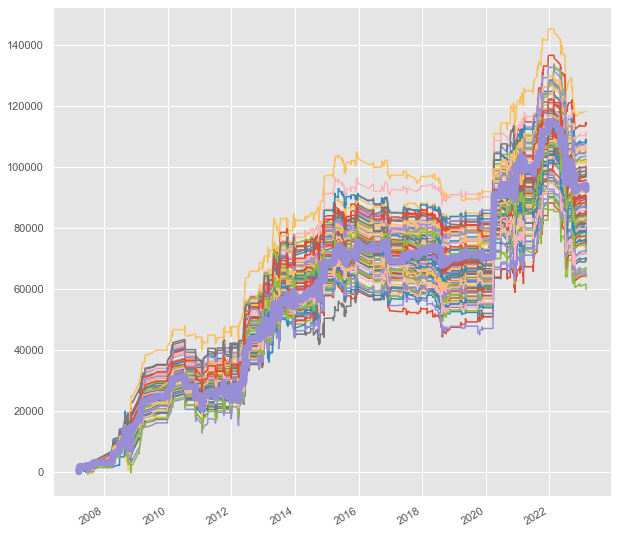

  0%|          | 0/100 [00:00<?, ?it/s]

Result %: 76.75


In [17]:
################### Test_Noise(n_test,original_tradelist,pct_noise,pct_pass_test,stampa,history)

result_test_noise = Test_Noise(100,tradelist.operations,20,10,1,dataset0)

print("Result %:" ,result_test_noise)

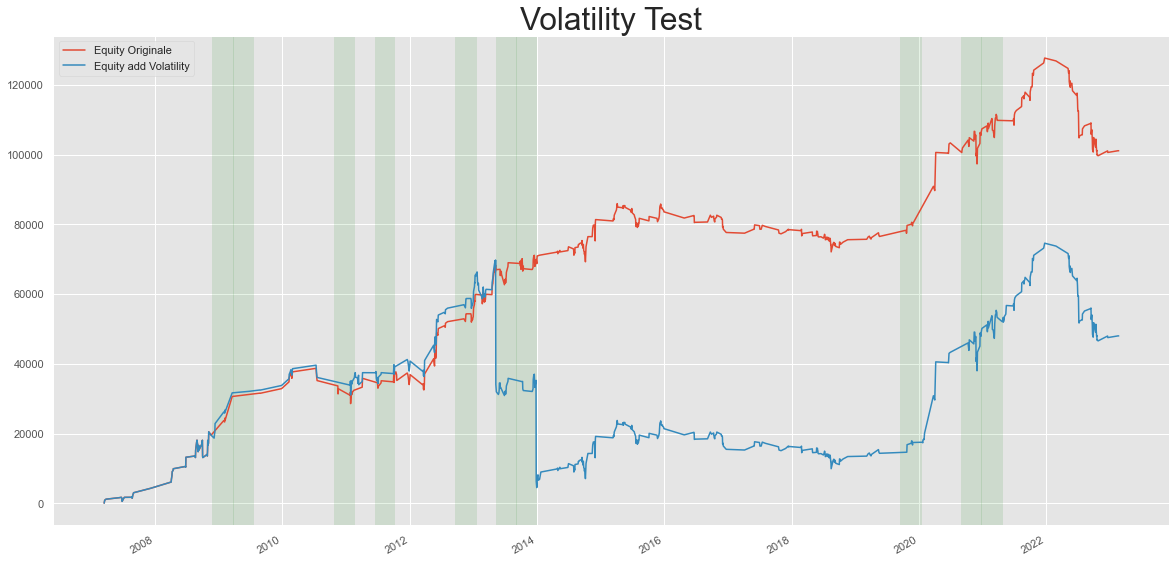

Test Volatility:

Profit Factor      : Equity_Originale 1.43 -  Equity_Variata 1.15  -> delta: 1.144 OK
Average Trade      : Equity_Originale 175.15 -  Equity_Variata 78.93  -> delta: 140.12 FAILL !!!
Reward Risk Ratio  : Equity_Originale 1.18 -  Equity_Variata 0.92  -> delta: 0.944 FAILL !!!
Max Draw Down      : Equity_Originale -16680.0 -  Equity_Variata -42362.0  -> delta: -20016.0 FAILL !!!




1

In [26]:
N_BARS_ADD_VOL = 500
VOL_ADD_PCT = 20
N_TEST = 10

#########################################################################
dataset = dataset0.copy()
data = np.array_split(dataset, len(dataset)//N_BARS_ADD_VOL)

columns = ["open","high","low","close","volume"]

add_vol_time = []

test_V = np.random.choice(data,N_TEST)
for i in test_V:
    rand = np.random.choice([0,1])
    if rand == 0:
        for e in columns:
            i[e] = i[e] + (i[e]*VOL_ADD_PCT)/100
    else:
        for e in columns:
            i[e] = i[e] - (i[e]*VOL_ADD_PCT)/100
    
    add_vol_time.append([i.index[0],i.index[-1]])
    dataset.loc[i.index[0]:i.index[-1]] = i
    
tradelist_vol = test_long(dataset,exit_long,costi,entry_rule_long)

tradelist.operations.cumsum().plot(figsize=(20,10),label="Equity Originale",title="Volatility Test")
tradelist_vol.operations.cumsum().plot(figsize=(20,10),label="Equity add Volatility")
for ln in range(len(add_vol_time)):
    a2,a2b=add_vol_time[ln][0], add_vol_time[ln][1]
    plt.axvspan(a2,a2b,alpha=0.1, color='green',label ="",)

plt.legend()
plt.show()

print("Test Volatility:")
print("")
performances_validation_IS_OS(tradelist.operations,tradelist_vol.operations,20)

In [27]:
N_OOS_TRADE = 10
N_TEST =  500


tradelist_o = pd.Series(tradelist.operations.copy().values)
index = list(range(tradelist_o.index[-1],tradelist_o.index[-1]+N_OOS_TRADE))

ls_test=[]
x_sum=0
for e in range(N_TEST):
    x=tradelist_o.sample(N_OOS_TRADE).values
    ls_test.append(pd.Series(data=x,index=index))
    x_sum=x_sum+pd.Series(data=x,index=index)
x_sum=x_sum/N_TEST

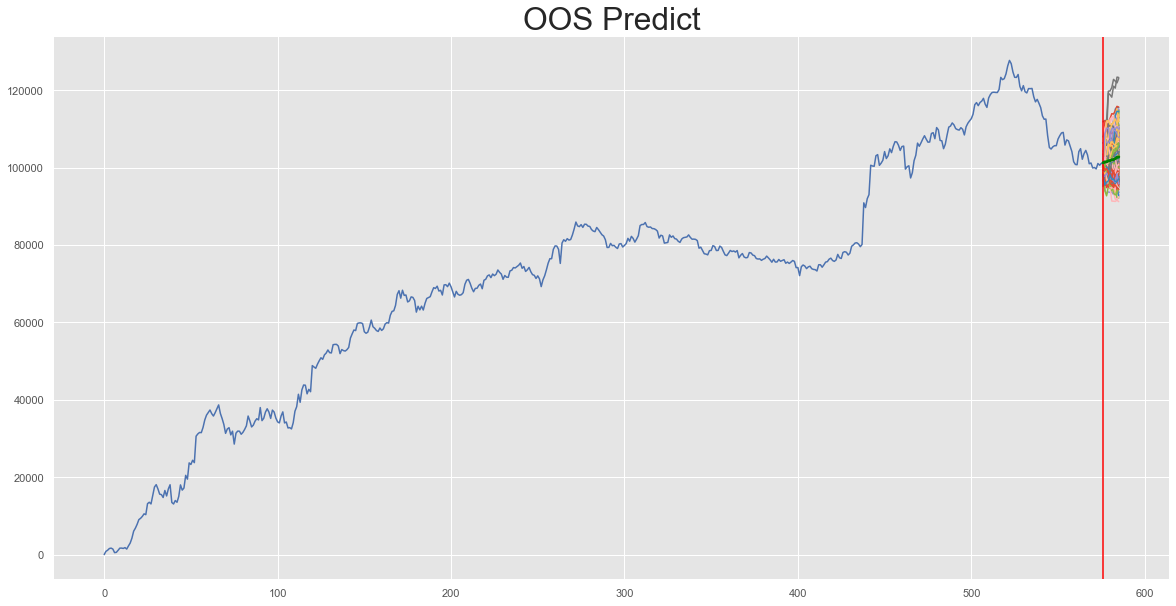

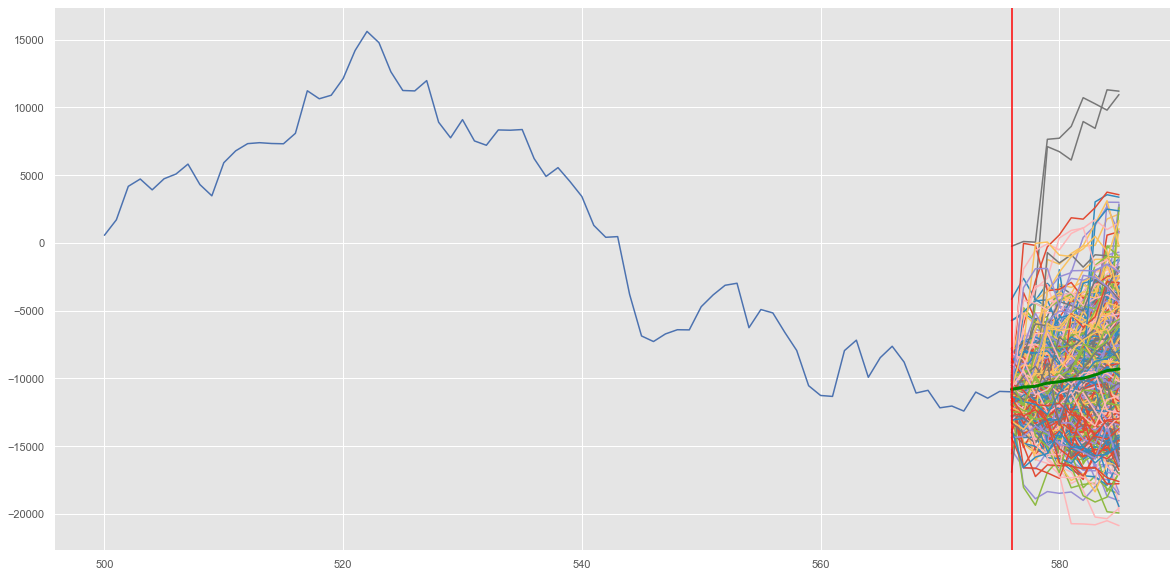

In [28]:
tradelist_o.cumsum().plot(figsize=(20,10),title="OOS Predict",color='b')
for e in ls_test:
    (e.cumsum()+tradelist_o.sum()).plot()
plt.axvline(x=ls_test[0].index[0] ,color="red")
(x_sum.cumsum()+tradelist_o.sum()).plot(color="green",linewidth=3)
plt.show()

tradelist_o.loc[500:].cumsum().plot(figsize=(20,10),label="OOS Predict",color='b')
for e in ls_test:
    (e.loc[500:].cumsum()+tradelist_o.loc[500:].sum()).plot()
    
(x_sum.loc[500:].cumsum()+tradelist_o.loc[500:].sum()).plot(color="green",linewidth=3)   
plt.axvline(x=ls_test[0].index[0] ,color="red")   
plt.show()

In [307]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 22})

In [379]:
dataset=dataset0.copy()
y=dataset.iloc[:,:5]
bk=y.copy()
X=y.copy()
X=X.fillna(0)
y=y.shift(-1)
y=y.fillna(0)

In [380]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42 , shuffle=False)

In [381]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

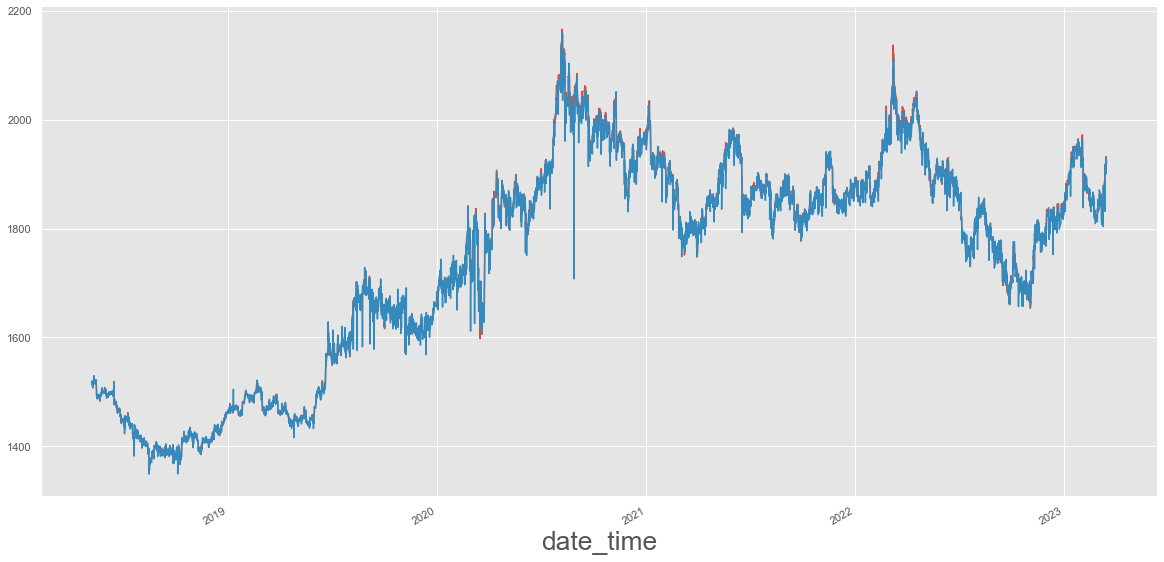

<AxesSubplot:xlabel='date_time'>

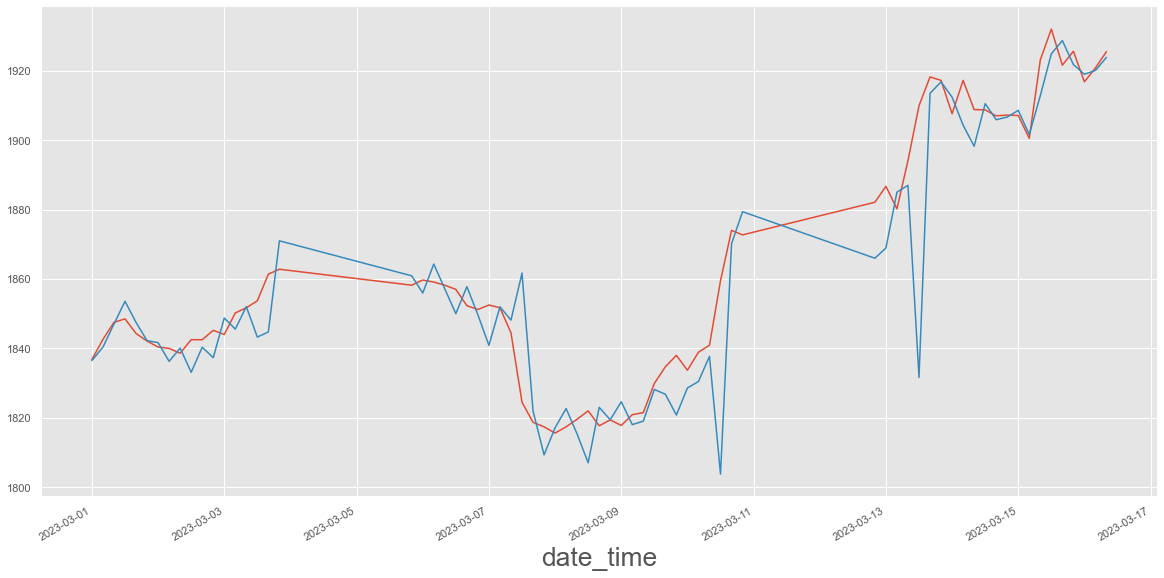

In [382]:
pred=regr.predict(X_test)
df=pd.DataFrame(pred)
#df=df.shift(100)
df.index=dataset.loc[y_test.index[0]:].index
df.columns=y.columns

dataset.close.loc[df.index[0]:].plot(figsize=(20,10))
df.close.loc[df.index[0]:].plot(figsize=(20,10))
plt.show()
dataset.close.loc["2023-03-01":].plot(figsize=(20,10))
df.close.loc["2023-03-01":].plot(figsize=(20,10))

In [376]:
tradelist_synthetic = test_long(df,exit_long,costi,entry_rule_long)

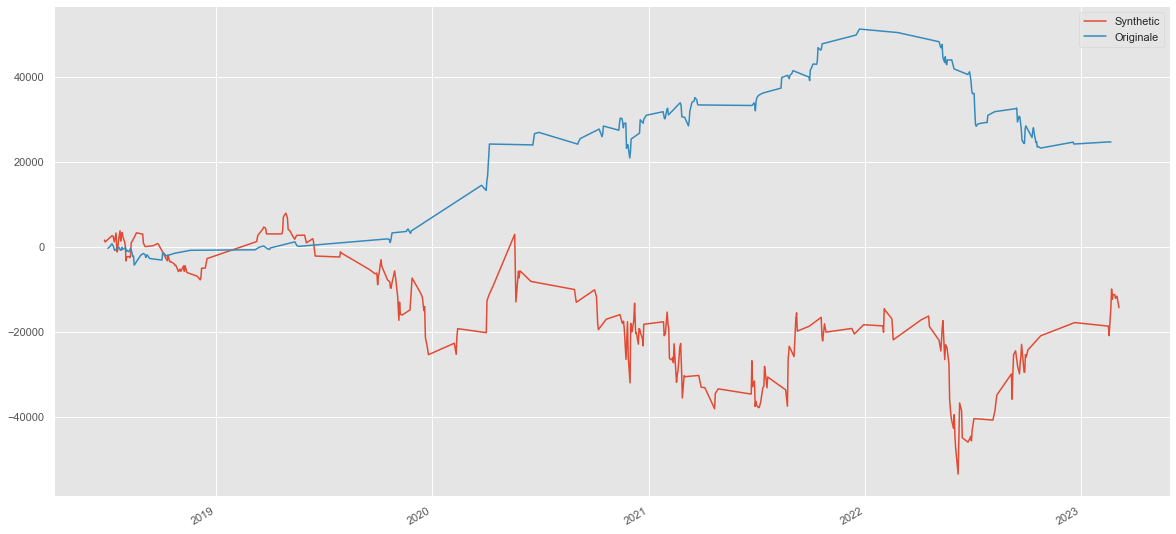

In [377]:
tradelist_synthetic.operations.cumsum().plot(figsize=(20,10),label="Synthetic")
tradelist.loc[tradelist_synthetic.index[0]:].operations.cumsum().plot(label="Originale")
plt.legend()
plt.show()

In [155]:
from scipy.stats import skewnorm
import pandas_ta as ta
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({'font.size': 22})


def simulate_stock(initial_price, drift, volatility, trend, days , OOS_date , TIMEFRAME):

    def create_pdf(sd, mean, alfa):
        #invertire il segno di alfa
        x = skewnorm.rvs(alfa, size=1000000) 
        def calc(k, sd, mean):
            return (k*sd)+mean
        x = calc(x, sd, mean) #standard distribution

        #graph pdf
        #pd.DataFrame(x).hist(bins=100)

        #pick one random number from the distribution
        #formally I would use cdf, but I just have to pick randomly from the 1000000 samples
        #np.random.choice(x)
        return x

    def create_empty_df(days):
    #creare un empty DataFrame con le date
        empty = pd.DatetimeIndex(
            pd.date_range(OOS_date, periods=days, freq=TIMEFRAME)
        )
        empty = pd.DataFrame(empty)
        #si tagliano ore, minuti, secondi
        empty

        #si tagliano ore, minuti, secondi
        empty.index = [str(x)[0:empty.shape[0]] for x in list(empty.pop(0))]
        empty

        #final dataset con values
        stock = pd.DataFrame([x for x in range(0, empty.shape[0])])
        stock.index = empty.index
        return stock

    #skeleton
    stock = create_empty_df(days)

    #initial price
    stock[0][0] = initial_price

    #create entire stock DataFrame
    x = create_pdf(volatility, drift, trend)
    from numba import jit
    @jit
    def fast_create(stock):
        for _ in range(1, stock.shape[0]):
            stock.iloc[_] = stock.iloc[_-1]*(1+np.random.choice(x))
        return stock
    
    stock = fast_create(stock)

    stock.index = pd.DatetimeIndex(stock.index)
    return stock


#normal distribution for difference between low and high
def create_pdf(sd, mean, alfa):
    #invertire il segno di alfa
    x = skewnorm.rvs(alfa, size=1000000) 
    def calc(k, sd, mean):
        return (k*sd)+mean
    x = calc(x, sd, mean) #standard distribution

    #graph pdf
    #pd.DataFrame(x).hist(bins=100)

    #pick one random number from the distribution
    #formally I would use cdf, but I just have to pick randomly from the 1000000 samples
    #np.random.choice(x)
    return x
ran = create_pdf(0.1, 0.2, 0)

def OCHL(group_values):
    min_ = min(group_values)
    max_ = max(group_values)
    range = max_ - min_
    open = min_+range*random.random()
    close = min_+range*random.random()
    return min_, max_, open, close

In [201]:
import plotly.graph_objects as go
import pandas as pd

OOS = "2023-03-16 16:00:00"
TIMEFRAME = "4H"

#simulate_stock(initial_price, drift, volatility, trend, days OOS_date , TIMEFRAME):
%time df = simulate_stock(1920.9, 0, 0.001, 0, 90000 , OOS , TIMEFRAME)

df_ = list()
#df.groupby(np.arange(len(df))//24).apply(OCHL) non funziona
#sarebbe il modo corretto, ma devo creare un nuovo df da 0
for a, b in df.groupby(np.arange(len(df))//24):
    group_values = np.array(b.values).flatten()
    low, high, open, close = OCHL(group_values)
    df_.append([low, high, open, close])

#
df_OCHL = pd.DataFrame(df_, index=pd.Series(pd.date_range(OOS, periods=len(df_), freq=TIMEFRAME)), columns=['low', 'high', 'open', 'close'])

df_OCHL["volume"]=0
     

Wall time: 16.6 s


In [206]:
dataset = pd.concat([dataset0.copy(),df_OCHL])

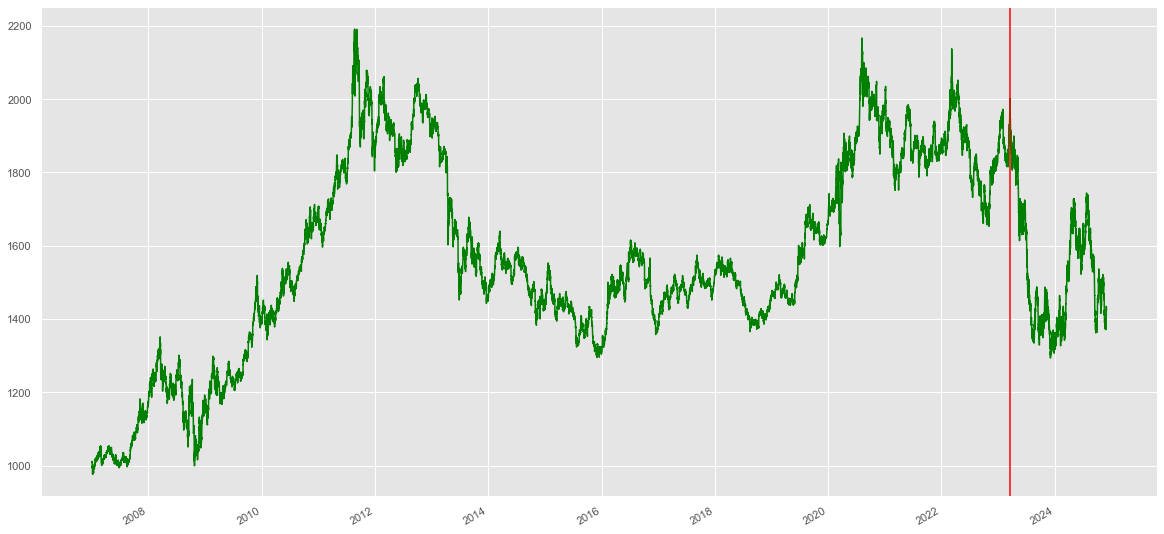

In [207]:
dataset.close.plot(figsize=(20,10),color="green")
plt.axvline(x=df_OCHL.index[0] ,color="red")   
plt.show()

In [208]:
tradelist_synthetic_2 = test_long(dataset,exit_long,costi,entry_rule_long)

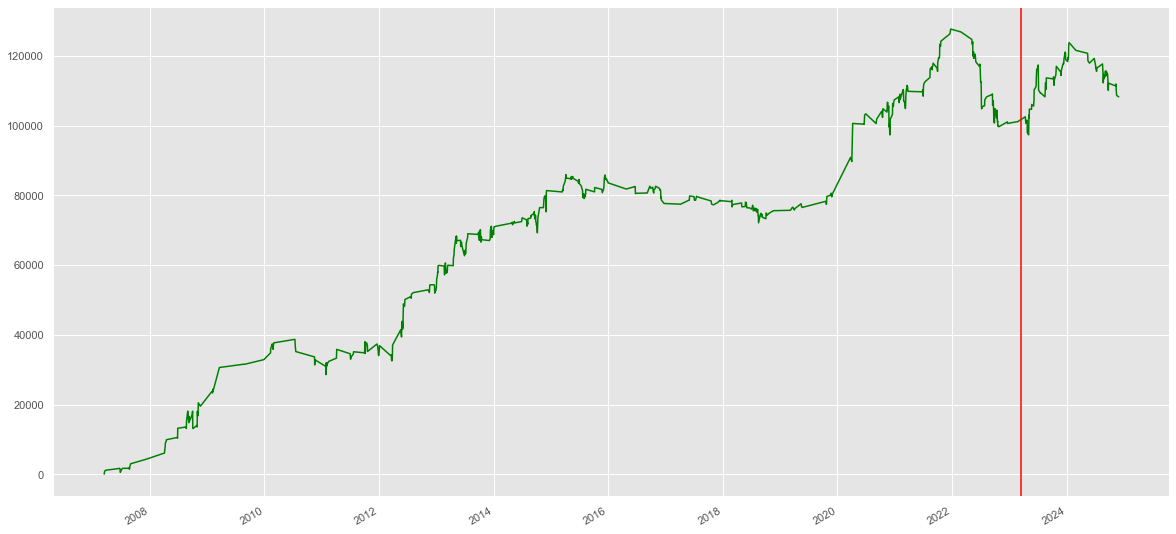

In [209]:
tradelist_synthetic_2.operations.cumsum().plot(figsize=(20,10),color="green")
plt.axvline(x=df_OCHL.index[0] ,color="red")   
plt.show()